# Objective

Determine the functional differences (if any exist to be found) in the proteome of the microbiome between RAG-Tcell Transfer (IBD Model) and RAG (Helthy Control) mice.  Ratio quantification using N15 isotopic labeling of the proteins of the microbiome should help to elucidate minor differences, while spectoral counting methods will be used to identify gross differences in proteomic content.

## Read and store sample data as classes

In [3]:
import sys
sys.path.append('..')
import os
from itertools import chain
import shelve
from tqdm import tqdm
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

from scripts import utils
from scripts.analysis import build_loci
from scripts.analysis.DBInfo import DBInfo

BASE = '../data'

db_info = DBInfo("compil_mgm")
metadata = build_loci.read_metadata(os.path.join(BASE,"metadata.csv"))

`metadata.csv` was generated using the script `make_metadata.py` located in the `scripts` directory.  This file extracts metadata about each sample encoded into the directory names, and places them into a csv file that is used by build loci to perform the correct analysis pipelines on a given sample.

In [4]:
samples = shelve.open(os.path.join(BASE,"Samples.shelve"))

for sample_name, sample_info in tqdm(list(metadata.iteritems())):
    sample = build_loci.Sample(sample_name, sample_info.path, db_info, sample_info)
    samples[sample.sample_name] = sample


100%|██████████| 65/65 [01:18<00:00,  1.48s/it]


In [5]:
protein_clusters = shelve.open(os.path.join(BASE,"Protein_clusters.shelve"))

for name, sample in tqdm(samples.items()):
    protein_clusters[name] = sample.build_protein_clusters()


100%|██████████| 65/65 [01:36<00:00,  1.30s/it]


Get the list of N15 quantified, unenriched samples.

In [6]:
unenr_keys = []
for key, sample in samples.items():
    if sample['quant'] and not sample['enriched']:
        unenr_keys.append(key)
unenr_keys = sorted(unenr_keys, key=lambda x: (x.split('_')[2], x.split('_')[-1], x.split('_')[-2]=='N'))

In [7]:
rt_un_keys = [key for key in unenr_keys if not '_N_' in key]
rag_un_keys = [key for key in unenr_keys if '_N_' in key]

## Plot venn diagrams showing run to run cluster composition for the samples

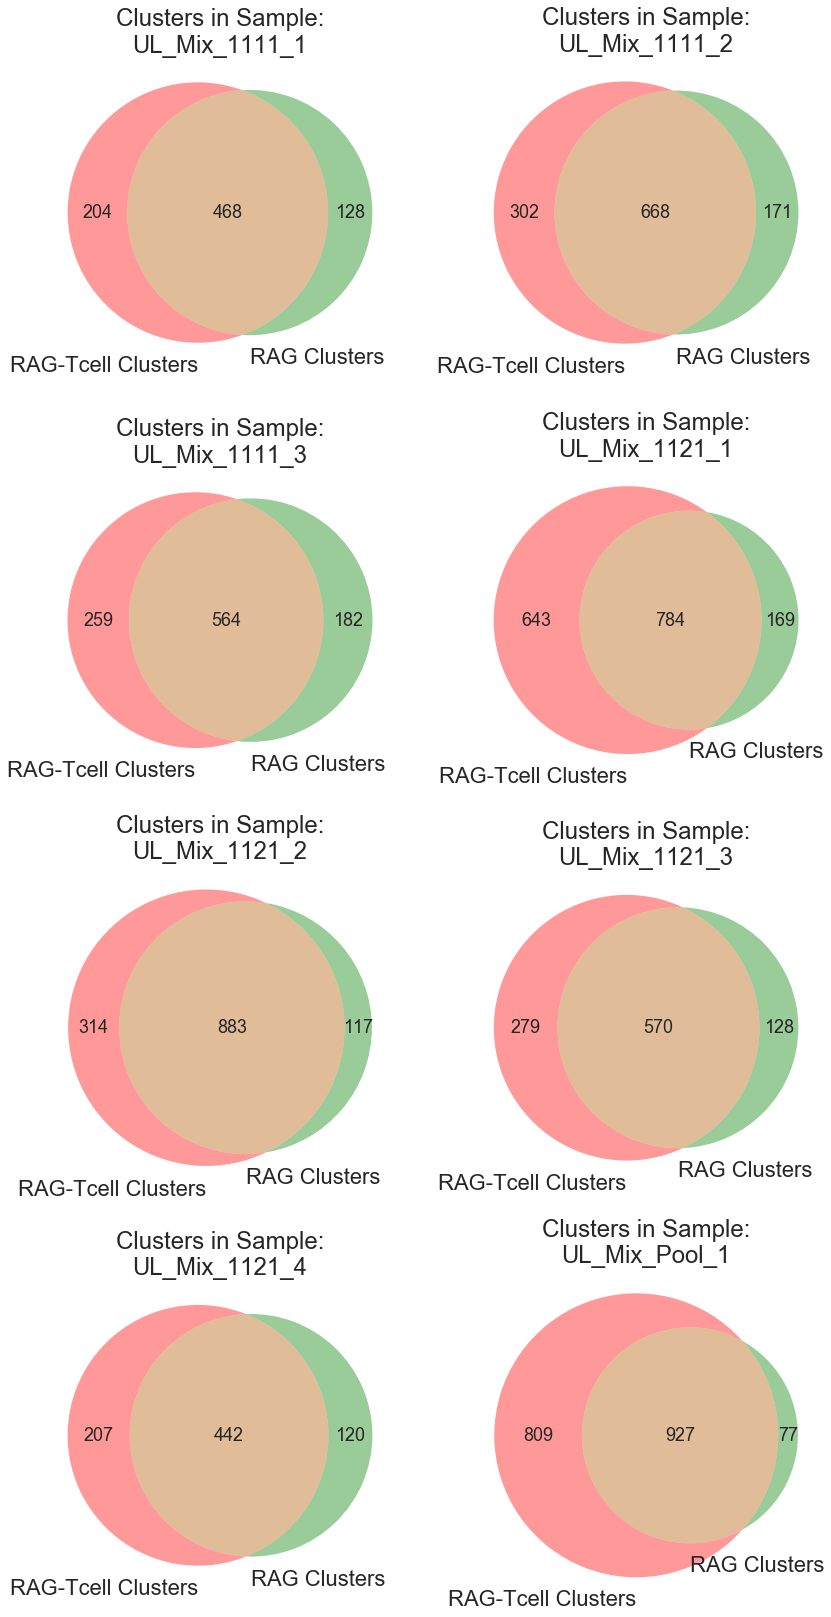

In [8]:
from matplotlib_venn import venn2

rows = len(unenr_keys)//4

fig, ax = plt.subplots(rows,2)
fig.set_tight_layout(False)
fig.set_size_inches(14,28)

for i, (l, h) in enumerate(zip(rt_un_keys, rag_un_keys)):
    light = set(p.cluster_id for p in protein_clusters[l])
    heavy = set(p.cluster_id for p in protein_clusters[h])
    
    v = venn2((light, heavy), ('RAG-Tcell Clusters', 'RAG Clusters'), ax = ax[i//2][i%2])
    
    for txt in v.set_labels:
        txt.set_fontsize(22)
    for text in v.subset_labels:
        text.set_fontsize(18)
    ax[i//2][i%2].set_title('Clusters in Sample:\n{}'.format(l), size = 24)

plt.savefig(os.path.join(BASE, 'unenr_clusters.png'), dpi = 100);

`UL_Mix_1121_1` (Row 2, Right side) and `UL_Mix_Pool_1` (Bottom Row, Right side) both look like they have diminished RAG Clusters, definitely looking different from the rest.  

## Make Datatables from the data

In [9]:
unenr_clusters = {k:v for k, v in protein_clusters.items() if k in unenr_keys}
"""
unenr_grouped_loci = build_loci.group_across_samples(list(chain(*unenr_clusters.values())), db_info)
for locus in tqdm(unenr_grouped_loci):
    locus.annotate()
    locus.quantify(rt_un_keys) #Only quantify ratios across N14 identifications
utils.save(unenr_grouped_loci, os.path.join(BASE,"unenriched_grouped_loci.pkl.gz"), force=True)
"""
unenr_grouped_loci = utils.load(os.path.join(BASE,"unenriched_grouped_loci.pkl.gz"))

In [10]:
unenr_samples = {k:v for k, v in samples.items() if k in unenr_keys}
nf = build_loci.yates_normalization(unenr_samples)

316 common peptides for Normalizaion


In [11]:
for locus in unenr_grouped_loci:
    locus.normalize(nf)
build_loci.to_json(unenr_grouped_loci, unenr_keys, os.path.join(BASE, 'unenriched_Rag_Tcell_ratio.json'))

### Datatable Link
**[Unenriched Protein Clusters](http://wl-cmadmin:8000/ratiotable/unenriched_Rag_Tcell_ratio)**

## PCA Plot of the Unenriched Samples

explained variance ratios: [ 0.17477816  0.14659874]


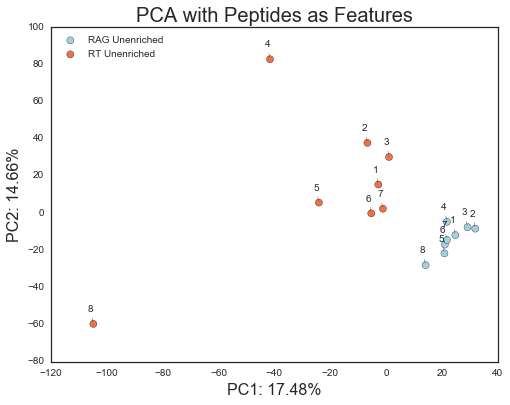

In [12]:
df = build_loci.to_df(unenr_grouped_loci, ratios=True, peptides=True)
build_loci.plot_pca(df, metadata[unenr_keys], title='PCA with Peptides as Features', group_name='category', loc=2, label_points=True)

explained variance ratios: [ 0.19837318  0.12780893]


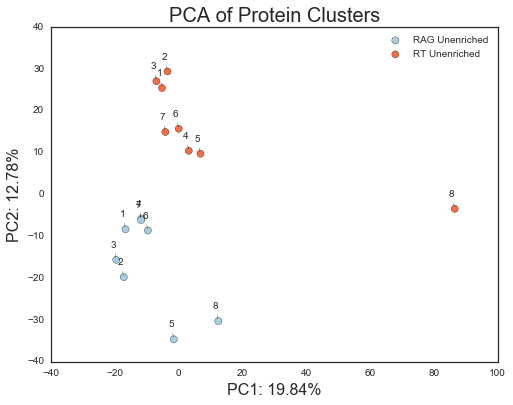

In [13]:
df = build_loci.to_df(unenr_grouped_loci, ratios=True, peptides=False)
build_loci.plot_pca(df, metadata[unenr_keys], group_name='category', loc=1, label_points=True)

Sample 8 definitely looks like an outlier, Sample 4 potentially, when examining by peptides.  Will try filtering them out and looking again.

In [14]:
prob_samp_numb = 8

problem_samples = []
problem_samples.append(rt_un_keys[prob_samp_numb-1])
problem_samples.append(rag_un_keys[prob_samp_numb-1])

for sample in problem_samples:
    unenr_keys.remove(sample)
    if sample in rt_un_keys:
        rt_un_keys.remove(sample)
    if sample in rag_un_keys:
        rag_un_keys.remove(sample)

In [15]:
unenr_clusters = {k:v for k, v in protein_clusters.items() if k in unenr_keys}
"""
unenr_grouped_loci = build_loci.group_across_samples(list(chain(*unenr_clusters.values())), db_info)
for locus in tqdm(unenr_grouped_loci):
    locus.annotate()
    locus.quantify(rt_un_keys) #Only quantify ratios across N14 identifications
utils.save(unenr_grouped_loci, os.path.join(BASE,"unenriched_grouped_loci_filt.pkl.gz"), force=True)
"""
unenr_grouped_loci = utils.load(os.path.join(BASE,"unenriched_grouped_loci_filt.pkl.gz"))

explained variance ratios: [ 0.19361528  0.144897  ]


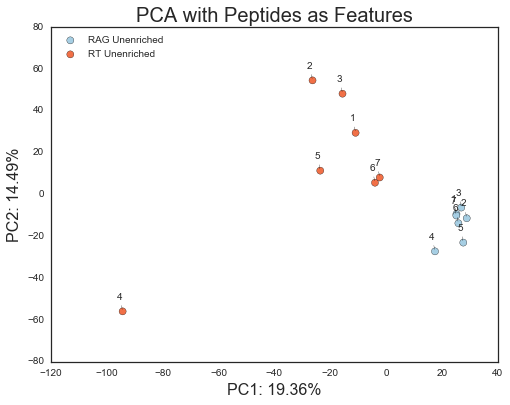

In [16]:
df = build_loci.to_df(unenr_grouped_loci, ratios=True, peptides=True)
build_loci.plot_pca(df, metadata[unenr_keys], title='PCA with Peptides as Features', group_name='category', loc=2, label_points=True)

explained variance ratios: [ 0.16515072  0.14020719]


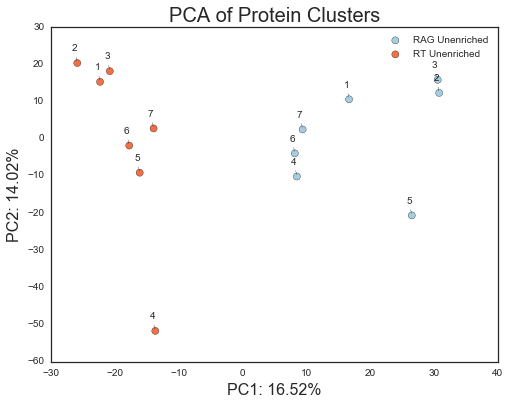

In [17]:
df = build_loci.to_df(unenr_grouped_loci, ratios=True, peptides=False)
build_loci.plot_pca(df, metadata[unenr_keys], group_name='category', loc=1, label_points=True)

In [18]:
prob_samp_numb = 4

problem_samples = []
problem_samples.append(rt_un_keys[prob_samp_numb-1])
problem_samples.append(rag_un_keys[prob_samp_numb-1])

for sample in problem_samples:
    unenr_keys.remove(sample)
    if sample in rt_un_keys:
        rt_un_keys.remove(sample)
    if sample in rag_un_keys:
        rag_un_keys.remove(sample)

In [20]:

unenr_clusters = {k:v for k, v in protein_clusters.items() if k in unenr_keys}
unenr_grouped_loci = build_loci.group_across_samples(list(chain(*unenr_clusters.values())), db_info)
for locus in tqdm(unenr_grouped_loci):
    locus.annotate()
    locus.quantify(rt_un_keys) #Only quantify ratios across N14 identifications
utils.save(unenr_grouped_loci, os.path.join(BASE,"unenriched_grouped_loci_filt1.pkl.gz"), force=True)

#unenr_grouped_loci = utils.load(os.path.join(BASE,"unenriched_grouped_loci_filt1.pkl.gz"))

load obo file ../scripts/go-basic.obo
46933 nodes imported
  0%|          | 0/2420 [00:00<?, ?it/s]/Users/mmayers/projects/n15_mice/venv/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/mmayers/projects/n15_mice/venv/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
100%|██████████| 2420/2420 [00:46<00:00, 52.57it/s]


explained variance ratios: [ 0.20345725  0.16497593]


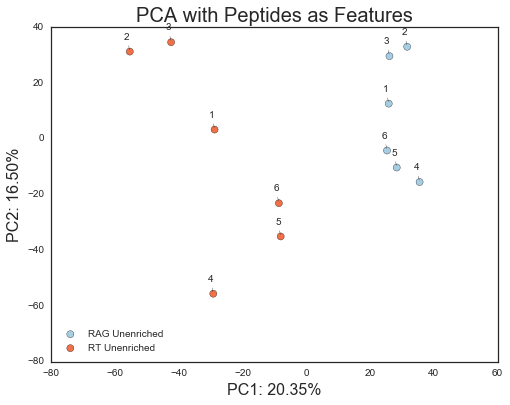

In [21]:
df = build_loci.to_df(unenr_grouped_loci, ratios=True, peptides=True)
build_loci.plot_pca(df, metadata[unenr_keys], title='PCA with Peptides as Features', group_name='category', loc=3, label_points=True)

explained variance ratios: [ 0.20337174  0.17285382]


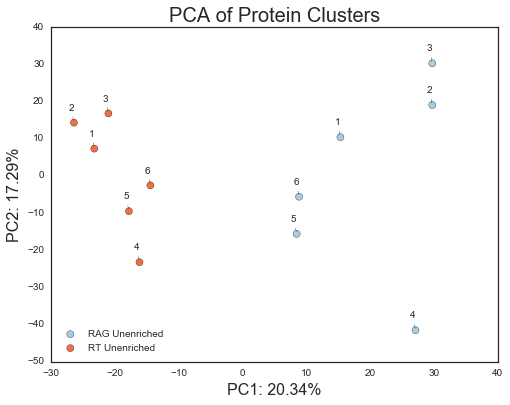

In [22]:
df = build_loci.to_df(unenr_grouped_loci, ratios=True, peptides=False)
build_loci.plot_pca(df, metadata[unenr_keys], group_name='category', loc=3, label_points=True)

# Enriched Samples

In [23]:
enr_keys = []
ctl_keys = []
for key, sample in samples.items():
    if sample['quant'] and sample['enriched'] and sample['probe'] == 'CMK':
        enr_keys.append(key)
    if sample['quant'] and sample['enriched'] and sample['probe'] == 'DMSO':
        ctl_keys.append(key)
enr_keys = sorted(enr_keys, key=lambda x: (x.split('_')[2], x.split('_')[-1], x.split('_')[-2]=='N'))
ctl_keys = sorted(ctl_keys, key=lambda x: (x.split('_')[2], x.split('_')[-1], x.split('_')[-2]=='N'))

In [24]:
rt_enr_keys = [key for key in enr_keys if not '_N_' in key]
rag_enr_keys = [key for key in enr_keys if '_N_' in key]

## Filter out clusters commonly found in DMSO Controls

If 10+ counts in a sample, most likely, this locus has a non-specific interaction to the beads, and isn't just noise

In [25]:
loci_to_filter = []
all_loci = []
for sample in ctl_keys:
    for locus in protein_clusters[sample]:
        if locus.quantification['counts'] > 10:
            loci_to_filter.append(locus.cluster_id)
        all_loci.append(locus.cluster_id)
loci_to_filter = set(loci_to_filter)
all_loci = set(all_loci)

In [26]:
len(loci_to_filter)

242

In [27]:
len(all_loci)

415

In [28]:
filt_clusters = dict()
for sample in enr_keys:
    count = 0
    a = protein_clusters[sample]
    print(sample, len(a), ':', end='')
    for locus in protein_clusters[sample]:
        if locus.cluster_id in loci_to_filter:
            a.remove(locus)
            count += 1
    print(len(a), ':', count)
    filt_clusters[sample] = a

CL_Mix_1120_1 1581 :1484 : 97
CL_Mix_1120_N_1 667 :636 : 31
CL_Mix_Pool_1 1550 :1398 : 152
CL_Mix_Pool_N_1 868 :829 : 39
CL_Mix_Pool_2 740 :637 : 103
CL_Mix_Pool_N_2 530 :500 : 30
CL_Mix_Pool_3 1147 :1023 : 124
CL_Mix_Pool_N_3 640 :604 : 36
CL_Mix_Pool_4 800 :681 : 119
CL_Mix_Pool_N_4 357 :326 : 31
CL_Mix_Pool_5 1568 :1434 : 134
CL_Mix_Pool_N_5 581 :545 : 36


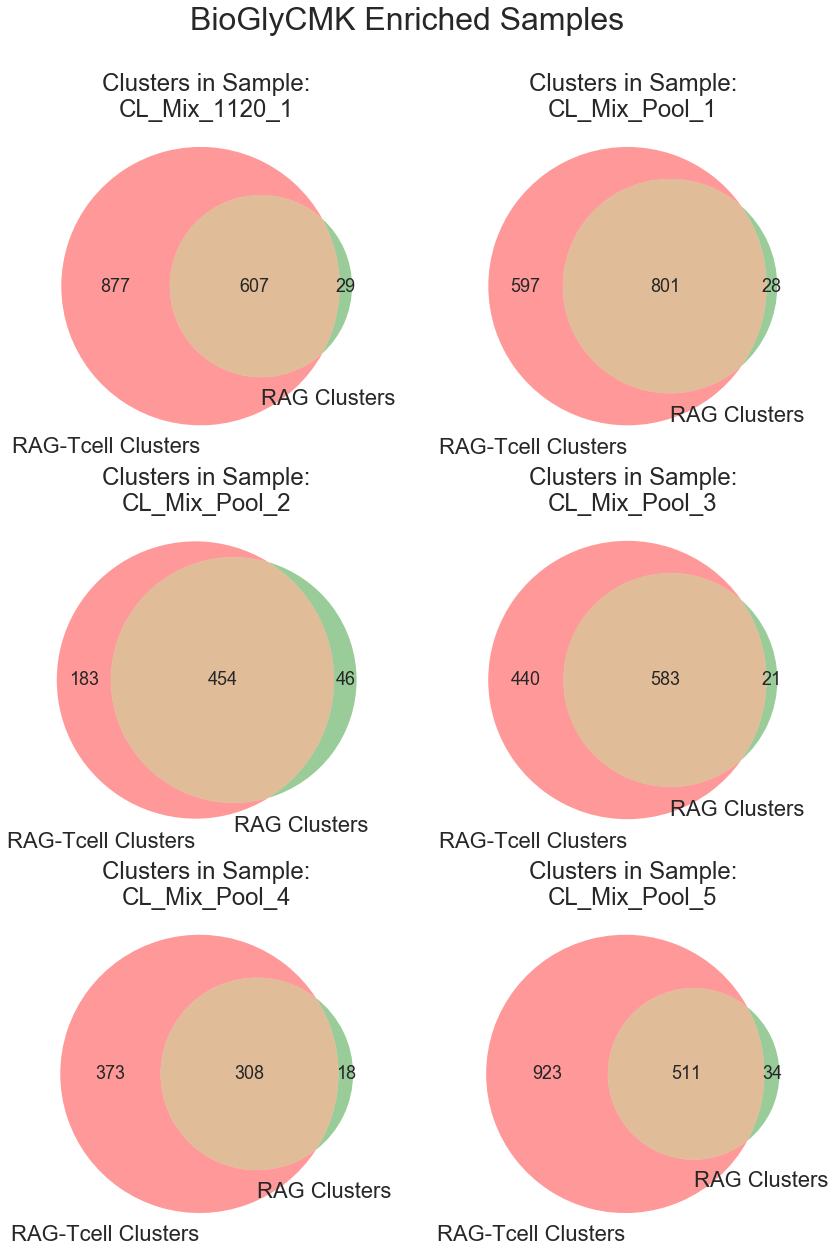

In [29]:
rows = len(enr_keys)//4

fig, ax = plt.subplots(rows,2)
fig.set_tight_layout(False)
fig.set_size_inches(14,20)
fig.suptitle('BioGlyCMK Enriched Samples', size=32)


for i, (l, h) in enumerate(zip(rt_enr_keys, rag_enr_keys)):
    light = set(p.cluster_id for p in filt_clusters[l])
    heavy = set(p.cluster_id for p in filt_clusters[h])
    
    v = venn2((light, heavy), ('RAG-Tcell Clusters', 'RAG Clusters'), ax = ax[i//2][i%2])
    
    for txt in v.set_labels:
        txt.set_fontsize(22)
    for text in v.subset_labels:
        text.set_fontsize(18)
    ax[i//2][i%2].set_title('Clusters in Sample:\n{}'.format(l), size = 24)

plt.savefig(os.path.join(BASE, 'enr_clusters.png'), dpi = 100);

In [30]:
"""
enr_grouped_loci = build_loci.group_across_samples(list(chain(*filt_clusters.values())), db_info)
for locus in tqdm(enr_grouped_loci):
    locus.annotate()
    locus.quantify(rt_enr_keys) #Only quantify ratios across N14 identifications
utils.save(enr_grouped_loci, os.path.join(BASE,"enriched_grouped_loci.pkl.gz"), force=True)
"""
enr_grouped_loci = utils.load(os.path.join(BASE,"enriched_grouped_loci.pkl.gz"))

In [31]:
enriched_samples = {k:v for k, v in samples.items() if k in enr_keys}
nf = build_loci.yates_normalization(enriched_samples)

292 common peptides for Normalizaion


In [32]:
for locus in enr_grouped_loci:
    locus.normalize(nf)
build_loci.to_json(enr_grouped_loci, enr_keys, '../data/bioGlyCMK_enriched_Rag_Tcell_ratio.json')

### Datatable of all loci and all samples
**[Link to Datatable](http://wl-cmadmin:8000/ratiotable/bioGlyCMK_enriched_Rag_Tcell_ratio)**

explained variance ratios: [ 0.23167535  0.20126283]


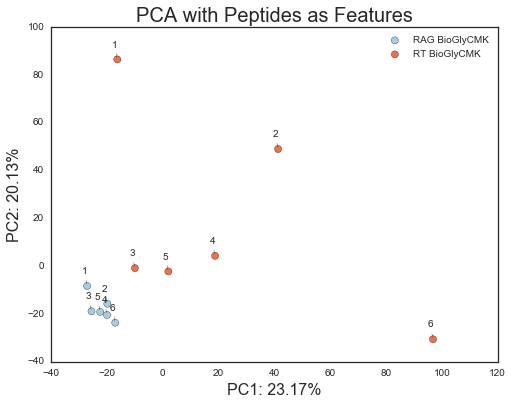

In [33]:
df = build_loci.to_df(enr_grouped_loci, ratios=True, peptides=True)
build_loci.plot_pca(df, metadata[enr_keys], title='PCA with Peptides as Features', group_name='category', loc=1, label_points=True)

explained variance ratios: [ 0.22260719  0.18551683]


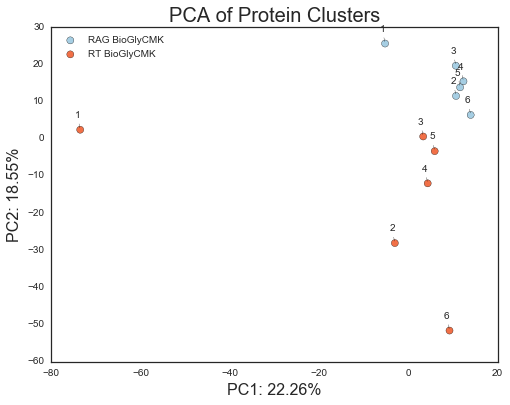

In [34]:
df = build_loci.to_df(enr_grouped_loci, ratios=True, peptides=False)
build_loci.plot_pca(df, metadata[enr_keys], group_name='category', loc=2, label_points=True)

In [35]:
def remove_prob_sample(prob_samp_numb, all_keys, l_keys, h_keys):

    problem_samples = []
    problem_samples.append(l_keys[prob_samp_numb-1])
    problem_samples.append(h_keys[prob_samp_numb-1])

    for sample in problem_samples:
        all_keys.remove(sample)
        if sample in l_keys:
            l_keys.remove(sample)
        if sample in h_keys:
            h_keys.remove(sample)
    
    return all_keys, l_keys, h_keys

In [36]:
enr_keys, rt_enr_keys, rag_enr_keys = remove_prob_sample(1, enr_keys, rt_enr_keys, rag_enr_keys)

"""
filt_clusters = {k:v for k, v in filt_clusters.items() if k in enr_keys}
enr_grouped_loci = build_loci.group_across_samples(list(chain(*filt_clusters.values())), db_info)
for locus in tqdm(enr_grouped_loci):
    locus.annotate()
    locus.quantify(rt_enr_keys) #Only quantify ratios across N14 identifications
utils.save(enr_grouped_loci, os.path.join(BASE,"enriched_grouped_loci_filt1.pkl.gz"), force=True)
"""
unenr_grouped_loci = utils.load(os.path.join(BASE,"enriched_grouped_loci_filt1.pkl.gz"))

  0%|          | 0/2261 [00:00<?, ?it/s]/Users/mmayers/projects/n15_mice/venv/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/mmayers/projects/n15_mice/venv/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
100%|██████████| 2261/2261 [00:41<00:00, 55.14it/s]


explained variance ratios: [ 0.28960327  0.23916774]


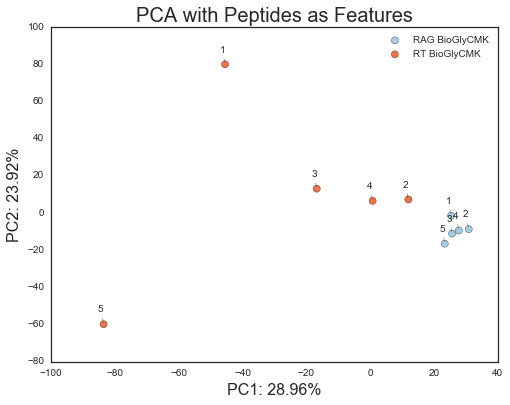

In [37]:
df = build_loci.to_df(enr_grouped_loci, ratios=True, peptides=True)
build_loci.plot_pca(df, metadata[enr_keys], title='PCA with Peptides as Features', group_name='category', loc=1, label_points=True)

explained variance ratios: [ 0.25002342  0.20808892]


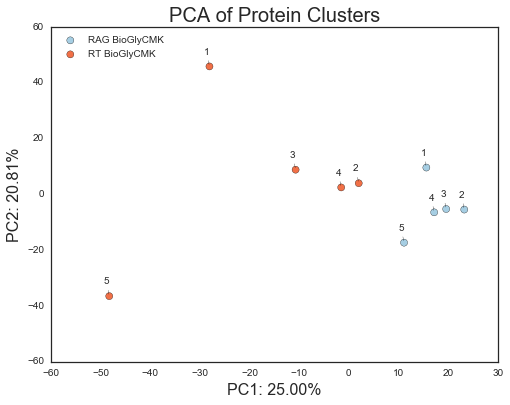

In [38]:
df = build_loci.to_df(enr_grouped_loci, ratios=True, peptides=False)
build_loci.plot_pca(df, metadata[enr_keys], group_name='category', loc=2, label_points=True)

In [39]:
enr_keys, rt_enr_keys, rag_enr_keys = remove_prob_sample(5, enr_keys, rt_enr_keys, rag_enr_keys)
"""
filt_clusters = {k:v for k, v in filt_clusters.items() if k in enr_keys}
enr_grouped_loci = build_loci.group_across_samples(list(chain(*filt_clusters.values())), db_info)
for locus in tqdm(enr_grouped_loci):
    locus.annotate()
    locus.quantify(rt_enr_keys) #Only quantify ratios across N14 identifications
utils.save(enr_grouped_loci, os.path.join(BASE,"enriched_grouped_loci_filt2.pkl.gz"), force=True)
"""
enr_grouped_loci = utils.load(os.path.join(BASE,"enriched_grouped_loci_filt2.pkl.gz"))

  0%|          | 0/1791 [00:00<?, ?it/s]/Users/mmayers/projects/n15_mice/venv/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
  0%|          | 7/1791 [00:00<00:26, 66.19it/s]/Users/mmayers/projects/n15_mice/venv/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
100%|██████████| 1791/1791 [00:31<00:00, 56.22it/s]


explained variance ratios: [ 0.35848356  0.18885053]


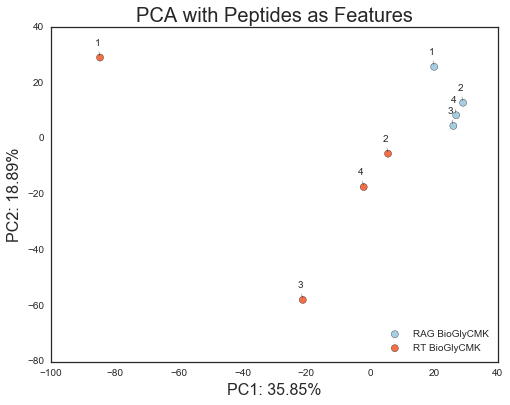

In [40]:
df = build_loci.to_df(enr_grouped_loci, ratios=True, peptides=True)
build_loci.plot_pca(df, metadata[enr_keys], title='PCA with Peptides as Features', group_name='category', loc=4, label_points=True)

explained variance ratios: [ 0.30323786  0.2065802 ]


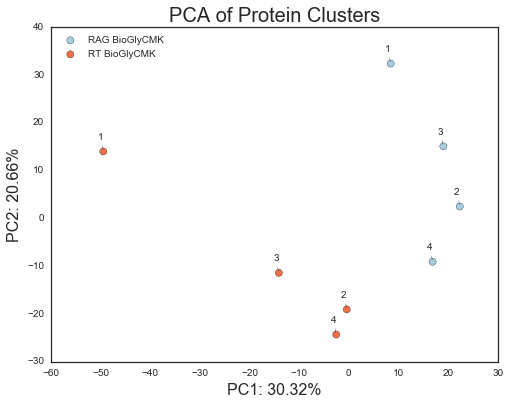

In [41]:
df = build_loci.to_df(enr_grouped_loci, ratios=True, peptides=False)
build_loci.plot_pca(df, metadata[enr_keys], group_name='category', loc=2, label_points=True)

In [42]:
both_clusters = filt_clusters
both_clusters.update(unenr_clusters)

In [43]:
grouped_loci = build_loci.group_across_samples(list(chain(*both_clusters.values())), db_info)
"""
for locus in tqdm(grouped_loci):
    locus.annotate()
    locus.quantify(rt_un_keys+rt_enr_keys) #Only quantify ratios across N14 identifications
utils.save(grouped_loci, os.path.join(BASE,"grouped_loci.pkl.gz"), force=True)
"""
grouped_loci = utils.load(os.path.join(BASE,"grouped_loci.pkl.gz"))

  0%|          | 0/3368 [00:00<?, ?it/s]/Users/mmayers/projects/n15_mice/venv/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/mmayers/projects/n15_mice/venv/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
100%|██████████| 3368/3368 [01:00<00:00, 55.95it/s]


explained variance ratios: [ 0.17793304  0.11276704]


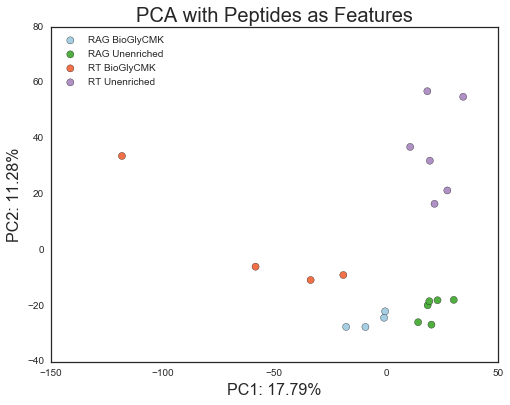

In [44]:
df = build_loci.to_df(grouped_loci, ratios=True, peptides=True)
build_loci.plot_pca(df, metadata[unenr_keys+enr_keys], title='PCA with Peptides as Features', group_name='category', loc=2, label_points=False)

explained variance ratios: [ 0.17917826  0.10448105]


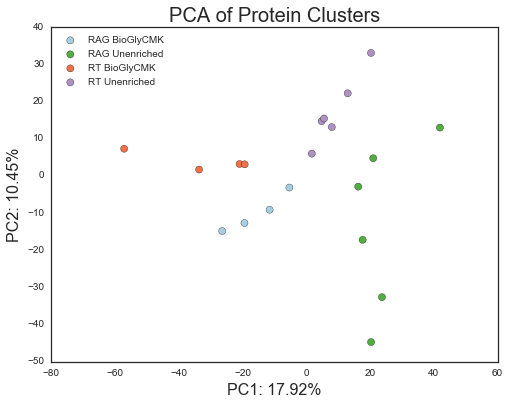

In [45]:
df = build_loci.to_df(grouped_loci, ratios=True, peptides=False)
build_loci.plot_pca(df, metadata[unenr_keys+enr_keys], group_name='category', loc=2, label_points=False)

# Volcano plot for significantly enriched loci

In [46]:
"""
rt_clusters = {k:v for k, v in protein_clusters.items() if k in rt_un_keys}
rt_un_grouped_loci = build_loci.group_across_samples(list(chain(*rt_clusters.values())), db_info)
for locus in tqdm(rt_un_grouped_loci):
    locus.annotate()
    locus.quantify()
utils.save(rt_un_grouped_loci, os.path.join(BASE,"ragtcell_unenriched_grouped_loci.pkl.gz"), force=True)
"""
rt_un_grouped_loci = utils.load(os.path.join(BASE,"ragtcell_unenriched_grouped_loci.pkl.gz"))

  0%|          | 0/2137 [00:00<?, ?it/s]/Users/mmayers/projects/n15_mice/venv/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/mmayers/projects/n15_mice/venv/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
100%|██████████| 2137/2137 [00:37<00:00, 57.61it/s]


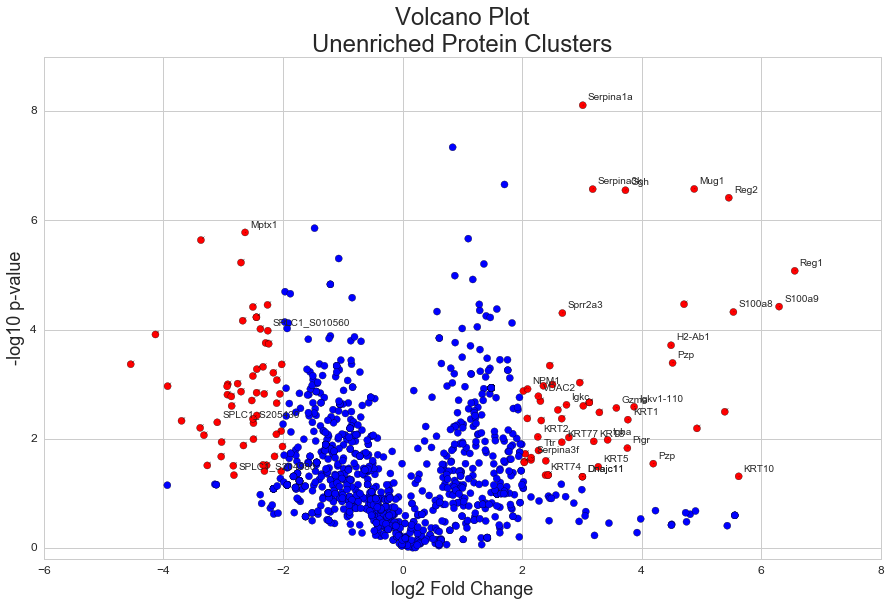

In [47]:
build_loci.plot_volcano(rt_un_grouped_loci, title='Volcano Plot\nUnenriched Protein Clusters', labels=True)

In [48]:
build_loci.sig_up_json(rt_un_grouped_loci, rt_un_keys, os.path.join(BASE, 'unenriched_sig_up.json'), norm=False)
build_loci.sig_down_json(rt_un_grouped_loci, rt_un_keys, os.path.join(BASE, 'unenriched_sig_down.json'), norm=False)

## The list of up and downregulated Protein Clusters can be found here:  
**[Significantly upregulated in Tcell Transfer](http://wl-cmadmin:8000/ratiotable/nuenriched_sig_up)**  
**[Significantly downregulated in Tcell Transfer](http://wl-cmadmin:8000/ratiotable/unenriched_sig_down)**

### Enriched Samples

In [49]:
"""
rt_enr_clusters = {k:v for k, v in protein_clusters.items() if k in rt_enr_keys}
rt_enr_grouped_loci = build_loci.group_across_samples(list(chain(*rt_enr_clusters.values())), db_info)
for locus in tqdm(rt_enr_grouped_loci):
    locus.annotate()
    locus.quantify()
utils.save(rt_enr_grouped_loci, os.path.join(BASE,"ragtcell_enriched_grouped_loci.pkl.gz"), force=True)
"""
rt_un_grouped_loci = utils.load(os.path.join(BASE,"ragtcell_enriched_grouped_loci.pkl.gz"))

  0%|          | 0/1910 [00:00<?, ?it/s]/Users/mmayers/projects/n15_mice/venv/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
  0%|          | 7/1910 [00:00<01:00, 31.38it/s]/Users/mmayers/projects/n15_mice/venv/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
100%|██████████| 1910/1910 [00:34<00:00, 55.17it/s]


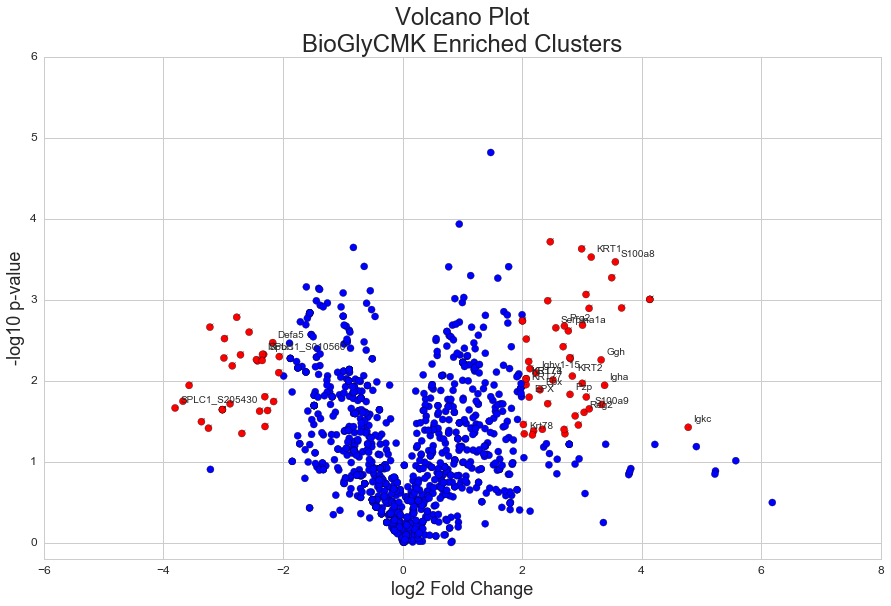

In [50]:
build_loci.plot_volcano(rt_enr_grouped_loci, title='Volcano Plot\nBioGlyCMK Enriched Clusters', labels=True)

In [51]:
build_loci.sig_up_json(rt_enr_grouped_loci, rt_enr_keys, os.path.join(BASE, 'enriched_sig_up.json'), norm=False)
build_loci.sig_down_json(rt_enr_grouped_loci, rt_enr_keys, os.path.join(BASE, 'enriched_sig_down.json'), norm=False)

## View Significance tables here:  
**[Significantly upregulated in Tcell Transfer](http://wl-cmadmin:8000/ratiotable/enriched_sig_up)**  
**[Significantly downregulated in Tcell Transfer](http://wl-cmadmin:8000/ratiotable/enriched_sig_down)**

# GESA

### Unenriched: RAG vs Tcell

In [80]:
from scripts.analysis import gsea
from collections import defaultdict
g = gsea.GSEA()

# Assign groups to each locus
groups = {'RAG': rag_un_keys, 'Tcell': rt_un_keys}

for locus in unenr_grouped_loci:
    locus.group = []
    samples_in_locus = {sample for sample, quant in locus.quantification.items() if quant['ratio'] > 0}
    for group, members in groups.items():
        if set(members) & samples_in_locus:
            locus.group.append(group)
    
# Get go terms for each group {CID: [GO_Terms], ...}
Rag = {locus.cluster_id:locus.annotations['go'] for locus in unenr_grouped_loci if 'RAG' in locus.group and 'go' in locus.annotations}
Tcell = {locus.cluster_id:locus.annotations['go'] for locus in unenr_grouped_loci if 'Tcell' in locus.group and 'go' in locus.annotations}

rag_annot = defaultdict(list)
tcell_annot = defaultdict(list)

rag_annot.update(g.generate_go_sets(Rag))
tcell_annot.update(g.generate_go_sets(Tcell))

annotations = {locus.cluster_id:locus.annotations['go'] for locus in unenr_grouped_loci if 'go' in locus.annotations}
annotations = g.generate_go_sets(annotations)

all_annotations = set(list(rag_annot.keys()) + list(tcell_annot.keys()))



load obo file ../scripts/go-basic.obo
46933 nodes imported


In [79]:
# pop is group1 + group2
def enrichment(num_in_sub, num_in_pop, len_sub, len_pop, verbose = True):
    import scipy.stats as stats

    pval = stats.hypergeom.sf(num_in_sub - 1, len_pop, num_in_pop, len_sub)
    if verbose:
        print('number with condition in population: ' + str(num_in_pop))
        print('length pop: ' + str(len_pop))
        print('number with condition in subset: ' + str(num_in_sub))
        print('length sub: ' + str(len_sub))
        print('p-value >= ' + str(num_in_sub) + ': ' + str(pval))
    return pval

### RAG vs TCell

In [129]:
pv = dict()
for annotation in all_annotations:
    # number with condition in population
    num_in_pop = len(set(rag_annot[annotation])|set(tcell_annot[annotation]))
    # number with condition in subset
    num_in_sub = len(rag_annot[annotation])
    # number of proteins/clusters in pop
    len_pop = len(set(Rag.keys())|set(Tcell.keys()))
    # number of proteins/clusters in subset
    len_sub = len(Rag)
    pv[annotation] = enrichment(num_in_sub, num_in_pop, len_sub, len_pop, verbose=False)

[g.go_ontology[go].name for go in {k for k,v in pv.items() if v<0.0002}]
pd.Series({g.go_ontology[k].name:v for k,v in pv.items() if v<0.0002}).to_frame().rename(columns={0:'p-value'}).sort_values(by=['p-value'])


,p-value
purine ribonucleotide metabolic process,5.845963e-14
purine ribonucleoside monophosphate metabolic process,5.845963e-14
nucleoside metabolic process,5.845963e-14
purine ribonucleoside metabolic process,7.285575e-14
purine ribonucleoside triphosphate metabolic process,9.078360e-14
nucleotidyltransferase activity,2.275955e-06
nucleic acid metabolic process,3.766449e-06
small molecule binding,5.085020e-06
cellular macromolecule metabolic process,5.212295e-06
carbohydrate derivative binding,1.110256e-05


### Tcell vs RAG

In [130]:
pv = dict()
for annotation in all_annotations:
    # number with condition in population
    num_in_pop = len(set(tcell_annot[annotation])|set(rag_annot[annotation]))
    # number with condition in subset
    num_in_sub = len(tcell_annot[annotation])
    # number of proteins/clusters in pop
    len_pop = len(set(Tcell.keys())|set(Rag.keys()))
    # number of proteins/clusters in subset
    len_sub = len(Tcell)
    pv[annotation] = enrichment(num_in_sub, num_in_pop, len_sub, len_pop, verbose=False)

[g.go_ontology[go].name for go in {k for k,v in pv.items() if v<0.0002}]
pd.Series({g.go_ontology[k].name:v for k,v in pv.items() if v<0.0002}).to_frame().rename(columns={0:'p-value'}).sort_values(by=['p-value'])


,p-value
cellular metabolic process,7.913205e-49
carboxylic acid metabolic process,1.618637e-16
ribonucleoside monophosphate metabolic process,1.745778e-08
purine nucleoside monophosphate metabolic process,1.955081e-08


## Enriched

In [72]:
# Assign groups to each locus
groups = {'RAG': rag_enr_keys, 'Tcell': rt_enr_keys}

for locus in enr_grouped_loci:
    locus.group = []
    samples_in_locus = {sample for sample, quant in locus.quantification.items() if quant['ratio'] > 0}
    for group, members in groups.items():
        if set(members) & samples_in_locus:
            locus.group.append(group)
    
# Get go terms for each group {CID: [GO_Terms], ...}
Rag = {locus.cluster_id:locus.annotations['go'] for locus in enr_grouped_loci if 'RAG' in locus.group and 'go' in locus.annotations}
Tcell = {locus.cluster_id:locus.annotations['go'] for locus in enr_grouped_loci if 'Tcell' in locus.group and 'go' in locus.annotations}

rag_annot = defaultdict(list)
tcell_annot = defaultdict(list)

rag_annot.update(g.generate_go_sets(Rag))
tcell_annot.update(g.generate_go_sets(Tcell))

annotations = {locus.cluster_id:locus.annotations['go'] for locus in enr_grouped_loci if 'go' in locus.annotations}
annotations = g.generate_go_sets(annotations)

all_annotations = set(list(rag_annot.keys()) + list(tcell_annot.keys()))



 ### RAG vs TCell

In [77]:
pv = dict()
for annotation in all_annotations:
    # number with condition in population
    num_in_pop = len(set(rag_annot[annotation])|set(tcell_annot[annotation]))
    # number with condition in subset
    num_in_sub = len(rag_annot[annotation])
    # number of proteins/clusters in pop
    len_pop = len(set(Rag.keys())|set(Tcell.keys()))
    # number of proteins/clusters in subset
    len_sub = len(Rag)
    pv[annotation] = enrichment(num_in_sub, num_in_pop, len_sub, len_pop, verbose=False)

[g.go_ontology[go].name for go in {k for k,v in pv.items() if v<0.005}] # only 4 samples, set thresh higher


['aldehyde-lyase activity',
 'metal ion binding',
 'catalytic complex',
 'metal cluster binding',
 'energy reserve metabolic process',
 'nucleotidyltransferase activity',
 'polysaccharide metabolic process',
 'zinc ion binding',
 'oxidation-reduction process',
 'lyase activity',
 'polysaccharide biosynthetic process',
 'cation binding',
 'monocarboxylic acid metabolic process',
 'binding']

### T-cell vs RAG

In [75]:
pv = dict()
for annotation in all_annotations:
    # number with condition in population
    num_in_pop = len(set(tcell_annot[annotation])|set(rag_annot[annotation]))
    # number with condition in subset
    num_in_sub = len(tcell_annot[annotation])
    # number of proteins/clusters in pop
    len_pop = len(set(Tcell.keys())|set(Rag.keys()))
    # number of proteins/clusters in subset
    len_sub = len(Tcell)
    pv[annotation] = enrichment(num_in_sub, num_in_pop, len_sub, len_pop, verbose=False)

[g.go_ontology[go].name for go in {k for k,v in pv.items() if v<0.05}] # only 4 samples, set thresh higher

['oxidoreductase activity',
 'cellular amino acid metabolic process',
 'oxidoreductase activity, acting on the aldehyde or oxo group of donors, NAD or NADP as acceptor',
 'carboxylic acid metabolic process',
 'carbohydrate metabolic process',
 'primary metabolic process']

## Enriched vs Unenriched

In [122]:
# Assign groups to each locus
groups = {'Enriched': enr_keys, 'Unenriched': unenr_keys}

for locus in grouped_loci:
    locus.group = []
    samples_in_locus = {sample for sample, quant in locus.quantification.items() if quant['ratio'] > 0}
    for group, members in groups.items():
        if set(members) & samples_in_locus:
            locus.group.append(group)
    
# Get go terms for each group {CID: [GO_Terms], ...}
enr = {locus.cluster_id:locus.annotations['go'] for locus in grouped_loci if 'Enriched' in locus.group and 'go' in locus.annotations}
unenr = {locus.cluster_id:locus.annotations['go'] for locus in grouped_loci if 'Unenriched' in locus.group and 'go' in locus.annotations}

enr_annot = defaultdict(list)
unenr_annot = defaultdict(list)

enr_annot.update(g.generate_go_sets(enr))
unenr_annot.update(g.generate_go_sets(unenr))

annotations = {locus.cluster_id:locus.annotations['go'] for locus in grouped_loci if 'go' in locus.annotations}
annotations = g.generate_go_sets(annotations)

all_annotations = set(list(enr_annot.keys()) + list(unenr_annot.keys()))



### Enriched vs Unenriched - Terms with more presence in Enriched Samples

In [126]:
pv = dict()
for annotation in all_annotations:
    # number with condition in population
    num_in_pop = len(set(enr_annot[annotation])|set(unenr_annot[annotation]))
    # number with condition in subset
    num_in_sub = len(enr_annot[annotation])
    # number of proteins/clusters in pop
    len_pop = len(set(enr.keys())|set(unenr.keys()))
    # number of proteins/clusters in subset
    len_sub = len(enr)
    pv[annotation] = enrichment(num_in_sub, num_in_pop, len_sub, len_pop, verbose=False)

pd.Series({g.go_ontology[k].name:v for k,v in pv.items() if v<0.0002}).to_frame().rename(columns={0:'p-value'}).sort_values(by=['p-value'])
#[g.go_ontology[go].name for go in {k for k,v in pv.items() if v<0.0002}] # only 4 samples, set thresh higher                                   

,p-value
cellular process,1.804996e-200
oxidoreductase activity,1.114611e-23
oxidation-reduction process,4.381683e-23
"oxidoreductase activity, acting on the aldehyde or oxo group of donors, NAD or NADP as acceptor",3.349307e-22
nucleoside-triphosphatase activity,9.077604e-17
cellular amino acid metabolic process,2.366330e-16
lyase activity,2.028613e-15
cytosolic part,6.456870e-14
cation binding,2.474636e-13
metal ion binding,3.461039e-13


### Unenriched vs Enriched - Terms with more presence in Unenriched samples

In [128]:
pv = dict()
for annotation in all_annotations:
    # number with condition in population
    num_in_pop = len(set(unenr_annot[annotation])|set(enr_annot[annotation]))
    # number with condition in subset
    num_in_sub = len(unenr_annot[annotation])
    # number of proteins/clusters in pop
    len_pop = len(set(unenr.keys())|set(enr.keys()))
    # number of proteins/clusters in subset
    len_sub = len(unenr)
    pv[annotation] = enrichment(num_in_sub, num_in_pop, len_sub, len_pop, verbose=False)

#pd.Series({g.go_ontology[k].name:v for k,v in pv.items() if v<0.0002}).to_frame().rename(columns={0:'p-value'}).sort_values(by=['p-value'])
[g.go_ontology[go].name for go in {k for k,v in pv.items() if v<0.002}] # only 4 samples, set thresh higher

['localization',
 'cellular aromatic compound metabolic process',
 'catabolic process',
 'transferase activity, transferring alkyl or aryl (other than methyl) groups',
 'phosphorylation',
 'purine ribonucleoside triphosphate binding',
 'nucleoside monophosphate metabolic process',
 'cellular macromolecule biosynthetic process',
 'translational elongation',
 'nucleotidyltransferase activity',
 'nucleic acid metabolic process',
 'phosphoenolpyruvate carboxykinase (ATP) activity',
 'translation',
 'phosphoglycerate kinase activity',
 'RNA binding',
 'purine ribonucleotide metabolic process',
 'ribonucleoside binding',
 'organonitrogen compound biosynthetic process',
 'nucleobase-containing compound biosynthetic process',
 'organic cyclic compound catabolic process',
 'transition metal ion binding',
 'macromolecule metabolic process',
 'locomotion',
 'cellular nitrogen compound biosynthetic process',
 'cellular metabolic process',
 'carbohydrate derivative binding',
 'nucleoside triphospha